# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import math

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
import os
os.listdir()

['terms_and_conditions',
 'Udacity_AZDIAS_Subset.csv',
 '.ipynb_checkpoints',
 'Udacity_CUSTOMERS_Subset.csv',
 '.Trash-0',
 'Identify_Customer_Segments.ipynb',
 'AZDIAS_Feature_Summary.csv',
 'Data_Dictionary.md']

In [3]:
with open("Udacity_AZDIAS_Subset.csv") as myfile:
    head = [next(myfile) for x in range(20)]
print(head)

['AGER_TYP;ALTERSKATEGORIE_GROB;ANREDE_KZ;CJT_GESAMTTYP;FINANZ_MINIMALIST;FINANZ_SPARER;FINANZ_VORSORGER;FINANZ_ANLEGER;FINANZ_UNAUFFAELLIGER;FINANZ_HAUSBAUER;FINANZTYP;GEBURTSJAHR;GFK_URLAUBERTYP;GREEN_AVANTGARDE;HEALTH_TYP;LP_LEBENSPHASE_FEIN;LP_LEBENSPHASE_GROB;LP_FAMILIE_FEIN;LP_FAMILIE_GROB;LP_STATUS_FEIN;LP_STATUS_GROB;NATIONALITAET_KZ;PRAEGENDE_JUGENDJAHRE;RETOURTYP_BK_S;SEMIO_SOZ;SEMIO_FAM;SEMIO_REL;SEMIO_MAT;SEMIO_VERT;SEMIO_LUST;SEMIO_ERL;SEMIO_KULT;SEMIO_RAT;SEMIO_KRIT;SEMIO_DOM;SEMIO_KAEM;SEMIO_PFLICHT;SEMIO_TRADV;SHOPPER_TYP;SOHO_KZ;TITEL_KZ;VERS_TYP;ZABEOTYP;ALTER_HH;ANZ_PERSONEN;ANZ_TITEL;HH_EINKOMMEN_SCORE;KK_KUNDENTYP;W_KEIT_KIND_HH;WOHNDAUER_2008;ANZ_HAUSHALTE_AKTIV;ANZ_HH_TITEL;GEBAEUDETYP;KONSUMNAEHE;MIN_GEBAEUDEJAHR;OST_WEST_KZ;WOHNLAGE;CAMEO_DEUG_2015;CAMEO_DEU_2015;CAMEO_INTL_2015;KBA05_ANTG1;KBA05_ANTG2;KBA05_ANTG3;KBA05_ANTG4;KBA05_BAUMAX;KBA05_GBZ;BALLRAUM;EWDICHTE;INNENSTADT;GEBAEUDETYP_RASTER;KKK;MOBI_REGIO;ONLINE_AFFINITAET;REGIOTYP;KBA13_ANZAHL_PKW;PLZ8_AN

In [4]:
with open("AZDIAS_Feature_Summary.csv") as myfile:
    head = [next(myfile) for x in range(2)]
print(head)

['attribute;information_level;type;missing_or_unknown\n', 'AGER_TYP;person;categorical;[-1,0]\n']


In [5]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';', na_values=['X', 'XX'])

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)
print(azdias.head())
print(azdias.describe())
print(azdias.dtypes)

(891221, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1        

In [7]:
# How much missing data?
print(azdias.isnull().sum() * 100 / len(azdias))

AGER_TYP                  0.000000
ALTERSKATEGORIE_GROB      0.000000
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR               0.000000
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP                0.000000
LP_LEBENSPHASE_FEIN       0.544646
LP_LEBENSPHASE_GROB       0.544646
LP_FAMILIE_FEIN           0.544646
LP_FAMILIE_GROB           0.544646
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ          0.000000
PRAEGENDE_JUGENDJAHRE     0.000000
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(feat_info.shape)
print(feat_info)

(85, 4)
                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12  

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.

# X and XX have already been mapped to NaN in read_csv, so remove here using regexp

for index, feature in feat_info.iterrows():
    unknown_vals = ast.literal_eval(re.sub('(XX)|X','',feature['missing_or_unknown']))
    filter = azdias[feature['attribute']].isin(unknown_vals)
    azdias.loc[filter, feature['attribute']] = np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the dataset.
col_nan_percent = azdias.isnull().sum() * 100 / len(azdias)

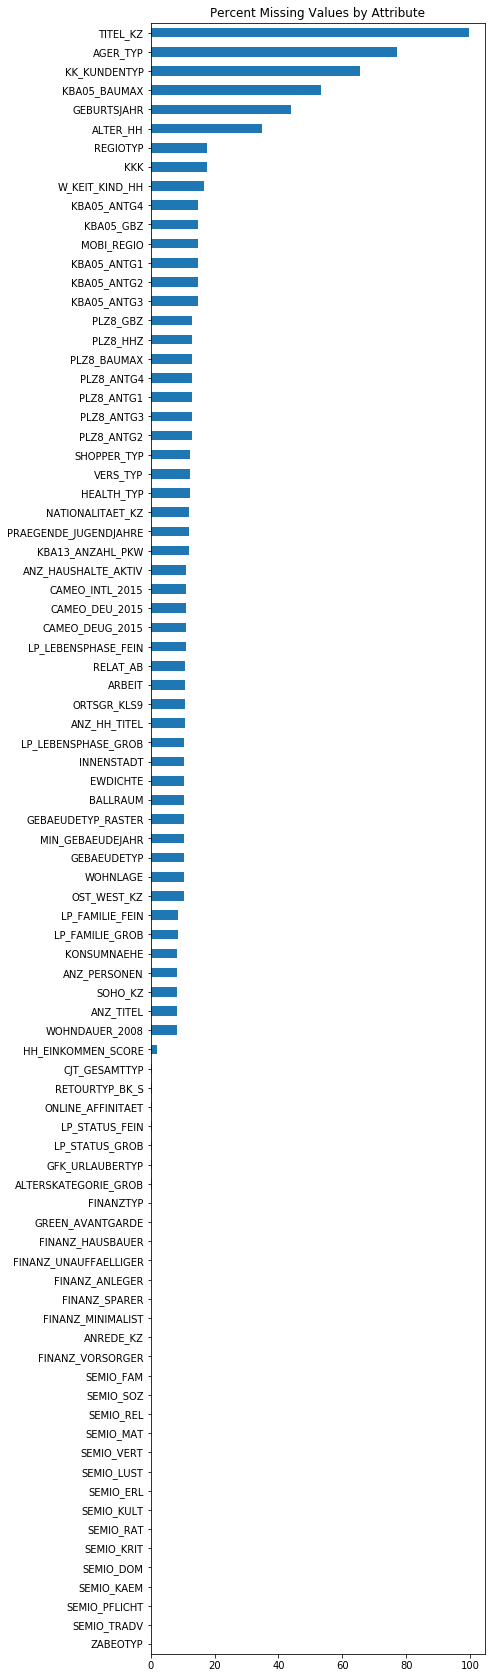

In [11]:
# Investigate patterns in the amount of missing data in each column.
col_nan_percent.sort_values().plot(kind="barh", figsize = (6, 30), title='Percent Missing Values by Attribute')
plt.show()

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

col_nan_threshold = 20
col_nan_remove = col_nan_percent[col_nan_percent > col_nan_threshold]
print(col_nan_remove)

# Drop columns from azdias
print('Shape before drop: ', azdias.shape)
azdias.drop(list(col_nan_remove.index), axis=1, inplace=True)
print('Shape after drop: ', azdias.shape)

# Drop corresponding rows from feat_info
updated_feat_info = feat_info[~feat_info['attribute'].isin(col_nan_remove.index)]


AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64
Shape before drop:  (891221, 85)
Shape after drop:  (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

Very high percentage of missing values in some columns (e.g. 76% in AGER_TYP).

Where the percentage of missing values exceeds a given threshold, we elect to remove the columns as not sufficient values to be useful.

In this instance, we have set the threshold at 20%, resulting in the removal of the following six columns:
* AGER_TYP
* GEBURTSJAHR
* TITEL_KZ
* ALTER_HH
* KK_KUNDENTYP
* KBA05_BAUMAX

The horizontal bar chart above also illustrates very high percentage of missing values in these six columns that we have just removed.

Other interesting points to note from the chart:
* The KBA05_ (number of family homes) columns all have the same percentage of missing values.
* The PLZ8_ (number of cars) columns all have the same percentage of missing values.
* The CAMEO_ (wealth / life stage) columns all have the same percentage of missing values.
* The FRANZ_ (finance typology) columns have no missing values.
* The SEMIO_ (personality) columns have no missing values.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [13]:
# How much data is missing in each row of the dataset?
row_nan_percent = azdias.isnull().sum(axis=1) * 100 / azdias.shape[1]


In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

row_nan_threshold = 20

subset1 = azdias[row_nan_percent < row_nan_threshold]  # few missing values
subset2 = azdias[row_nan_percent >= row_nan_threshold] # many missing values

ANREDE_KZ                0.0
FINANZ_MINIMALIST        0.0
FINANZ_SPARER            0.0
FINANZ_VORSORGER         0.0
FINANZ_ANLEGER           0.0
FINANZ_UNAUFFAELLIGER    0.0
FINANZ_HAUSBAUER         0.0
FINANZTYP                0.0
GREEN_AVANTGARDE         0.0
SEMIO_SOZ                0.0
SEMIO_FAM                0.0
SEMIO_REL                0.0
SEMIO_MAT                0.0
SEMIO_VERT               0.0
SEMIO_LUST               0.0
SEMIO_ERL                0.0
SEMIO_KULT               0.0
SEMIO_RAT                0.0
SEMIO_KRIT               0.0
SEMIO_DOM                0.0
SEMIO_KAEM               0.0
SEMIO_PFLICHT            0.0
SEMIO_TRADV              0.0
ZABEOTYP                 0.0
dtype: float64


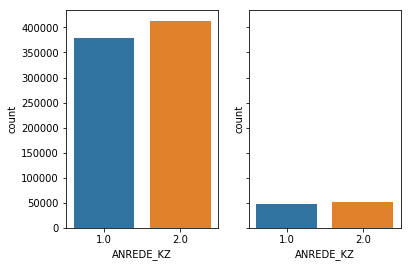

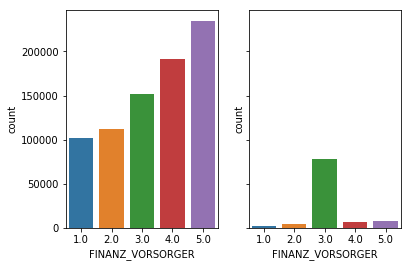

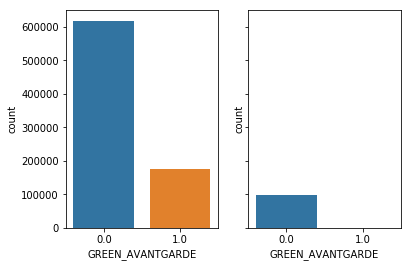

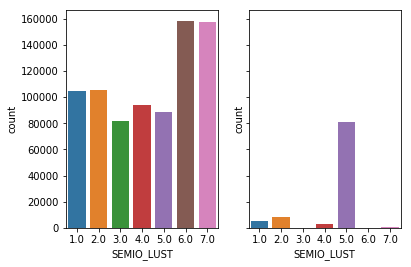

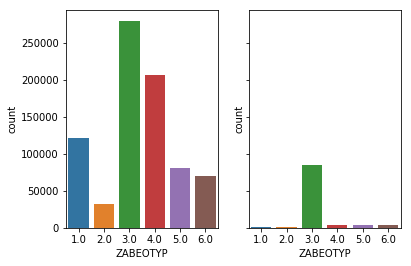

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

print(col_nan_percent[col_nan_percent.eq(0.0)])

chart_cols = (
'ANREDE_KZ',
'FINANZ_VORSORGER',
'GREEN_AVANTGARDE',
'SEMIO_LUST',
'ZABEOTYP')

for col in chart_cols:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    sns.countplot(subset1[col], ax=ax1)
    sns.countplot(subset2[col], ax=ax2)
    plt.show

#### Discussion 1.1.3: Assess Missing Data in Each Row

We have split our data set into two subsets of rows - "subset1" where the percent of missing values is less than a selected threshold and "subset2" where the percent of missing values is greater than the threshold. In this instance, we have set the threshold at 20%.

With these two data subsets, we have then charted above the distribution of values for the following five selected features:
* ANREDE_KZ (Gender)
* FINANZ_VORSORGER (Financial Precedent)
* GREEN_AVANTGARDE (Membership in environmental sustainability as part of youth)
* SEMIO_LUST (Personality type affinity attribute)
* ZABEOTYP (Energy consumption type)

The distribution looks similar across the two subsets for ANREDE_KZ (gender), but substantially different for the other attributes. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [16]:
# How many features are there of each data type?

print(feat_info['type'].value_counts())

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [17]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categoricals = updated_feat_info[feat_info['type'] == 'categorical']['attribute']

for c in categoricals:
    print(c)
    print(azdias[c].value_counts())


ANREDE_KZ
2.0    465305
1.0    425916
Name: ANREDE_KZ, dtype: int64
CJT_GESAMTTYP
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
FINANZTYP
6.0    290367
1.0    199572
4.0    130625
2.0    110867
5.0    106436
3.0     53354
Name: FINANZTYP, dtype: int64
GFK_URLAUBERTYP
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
GREEN_AVANTGARDE
0.0    715996
1.0    175225
Name: GREEN_AVANTGARDE, dtype: int64
LP_FAMILIE_FEIN
1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64
LP_FAMILIE_GROB
1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64
LP_STATUS_FEIN
1.0     

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
ZABEOTYP
3.0    364905
4.0    210095
1.0    123622
5.0     84956
6.0     74473
2.0     33170
Name: ZABEOTYP, dtype: int64
GEBAEUDETYP
1.0    460465
3.0    178668
8.0    152476
2.0      4935
4.0       900
6.0       628
5.0         1
Name: GEBAEUDETYP, dtype: int64
OST_WEST_KZ
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64
CAMEO_DEUG_2015
8.0    134441
9.0    108177
6.0    105874
4.0    103912
3.0     86779
2.0     83231
7.0     77933
5.0     55310
1.0     36212
Name: CAMEO_DEUG_2015, dtype: int64
CAMEO_DEU_2015
6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     607

In [18]:
# Re-encode categorical variable(s) to be kept in the analysis.

ost_west_map = {'O':0, 'W':1}

print(subset1['OST_WEST_KZ'].value_counts())
subset1['OST_WEST_KZ'] = subset1['OST_WEST_KZ'].map(ost_west_map)
print(subset1['OST_WEST_KZ'].value_counts())

W    624737
O    167550
Name: OST_WEST_KZ, dtype: int64
1    624737
0    167550
Name: OST_WEST_KZ, dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
# Drop multi-value categorical columns from azdias
col_mc_remove = [
'CJT_GESAMTTYP',
'FINANZTYP',
'GFK_URLAUBERTYP',
'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB',
'LP_STATUS_FEIN',
'LP_STATUS_GROB',
'NATIONALITAET_KZ',
'SHOPPER_TYP',
'ZABEOTYP',
'GEBAEUDETYP',
'CAMEO_DEUG_2015',
'CAMEO_DEU_2015'
]

print('Shape before drop: ', subset1.shape)
subset1.drop(col_mc_remove, axis=1, inplace=True)
print('Shape after drop: ', subset1.shape)


Shape before drop:  (792287, 79)
Shape after drop:  (792287, 66)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Discussion 1.2.1: Re-Encode Categorical Features

There are 21 categorical features and 7 mixed features.

For simplicity, we have elected to drop the following multi-value categorical features, while retaining the binary ones:
* CJT_GESAMTTYP
* FINANZTYP
* GFK_URLAUBERTYP
* LP_FAMILIE_FEIN
* LP_FAMILIE_GROB
* LP_STATUS_FEIN
* LP_STATUS_GROB
* NATIONALITAET_KZ
* SHOPPER_TYP
* ZABEOTYP
* GEBAEUDETYP
* CAMEO_DEUG_2015
* CAMEO_DEU_2015

We have re-encoded the OST_WEST_KZ binary feature so that it is numeric because our sklearn ML packages like to work with numeric inputs.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [20]:
# List the mixed-type features
print(updated_feat_info[feat_info['type'] == 'mixed']['attribute'])

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [21]:
print(subset1['PRAEGENDE_JUGENDJAHRE'].value_counts())

14.0    181525
8.0     140681
10.0     85276
5.0      84400
3.0      53615
15.0     42078
11.0     35448
9.0      33515
6.0      25629
12.0     24340
1.0      20550
4.0      20431
2.0       7470
13.0      5714
7.0       4000
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


In [22]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

decade_map = {
    1:40,
    2:40,
    3:50,
    4:50,
    5:60,
    6:60,
    7:60,
    8:70,
    9:70,
    10:80,
    11:80,
    12:80,
    13:80,
    14:90,
    15:90
}

# 0=Mainstream, 1=Avantgarde
movement_map = {
    1:0,
    2:1,
    3:0,
    4:1,
    5:0,
    6:1,
    7:1,
    8:0,
    9:1,
    10:0,
    11:1,
    12:0,
    13:1,
    14:0,
    15:1
}

subset1['YOUTH_DECADE'] = subset1['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
print(subset1['YOUTH_DECADE'].value_counts())

subset1['YOUTH_MOVEMENT'] = subset1['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
print(subset1['YOUTH_MOVEMENT'].value_counts())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


90.0    223603
70.0    174196
80.0    150778
60.0    114029
50.0     74046
40.0     28020
Name: YOUTH_DECADE, dtype: int64
0.0    590387
1.0    174285
Name: YOUTH_MOVEMENT, dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [23]:
print(subset1['CAMEO_INTL_2015'].value_counts())

51.0    133492
41.0     92080
24.0     90699
14.0     62565
43.0     56495
54.0     45287
25.0     39413
22.0     32931
13.0     26162
45.0     26038
23.0     26028
55.0     23866
52.0     20508
31.0     18661
34.0     18445
15.0     16913
44.0     14776
12.0     13136
35.0     10316
32.0     10304
33.0      9856
Name: CAMEO_INTL_2015, dtype: int64


In [24]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

subset1['WEALTH'] = subset1['CAMEO_INTL_2015'] // 10
print(subset1['WEALTH'].value_counts())

subset1['LIFE_STAGE'] = subset1['CAMEO_INTL_2015'] % 10
print(subset1['LIFE_STAGE'].value_counts())


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


5.0    223153
4.0    189389
2.0    189071
1.0    118776
3.0     67582
Name: WEALTH, dtype: int64
1.0    244233
4.0    231772
3.0    118541
5.0    116546
2.0     76879
Name: LIFE_STAGE, dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
# Drop the other mixed-type variables that don't require attention
col_mt_remove = [
    'LP_LEBENSPHASE_FEIN',
    'LP_LEBENSPHASE_GROB',
    'WOHNLAGE',
    'PLZ8_BAUMAX'
]

print('Shape before drop: ', subset1.shape)
subset1.drop(col_mt_remove, axis=1, inplace=True)
print('Shape after drop: ', subset1.shape)

Shape before drop:  (792287, 70)
Shape after drop:  (792287, 66)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


#### Discussion 1.2.2: Engineer Mixed-Type Features

Our mixed features are PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.

We have referred to the data dictionary and extracted the information for these attributes.


##### (1) PRAEGENDE_JUGENDJAHRE
Description: Dominating movement of person's youth

We extracted two new features YOUTH_DECADE and YOUTH_MOVEMENT (avantgarde or mainstream) and dropped the original feature PRAEGENDE_JUGENDJAHRE.


##### (2) CAMEO_INTL_2015
Description: Wealth / Life Stage Typology

We extracted two new features WEALTH (level of affluence) and LIFE_STAGE and dropped the original feature CAMEO_INTL_2015.


We dropped the remaining mixed-type variables that are not as interesting to us.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [26]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

print('Shape before drop: ', subset1.shape)
subset1.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
subset1.drop('CAMEO_INTL_2015', axis=1, inplace=True)
print('Shape after drop: ', subset1.shape)


Shape before drop:  (792287, 66)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Shape after drop:  (792287, 64)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

pd.set_option('display.max_columns', 100)
subset1.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,YOUTH_DECADE,YOUTH_MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,90.0,0.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,90.0,1.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,70.0,0.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,70.0,0.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,50.0,0.0,5.0,4.0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,4.0,2.0,5.0,5.0,7.0,2.0,6.0,5.0,5.0,7.0,7.0,4.0,7.0,7.0,7.0,0.0,1.0,1.0,0.0,6.0,3.0,9.0,4.0,0.0,5.0,1992.0,1,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,5.0,5.0,4.0,6.0,3.0,80.0,0.0,2.0,2.0
7,1.0,1.0,3.0,3.0,4.0,1.0,3.0,2.0,0.0,1.0,5.0,7.0,7.0,7.0,5.0,6.0,2.0,2.0,7.0,5.0,1.0,1.0,2.0,5.0,5.0,0.0,1.0,1.0,0.0,4.0,5.0,9.0,6.0,0.0,3.0,1992.0,1,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,4.0,4.0,2.0,5.0,2.0,70.0,0.0,1.0,4.0
8,3.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,1.0,3.0,4.0,4.0,5.0,4.0,1.0,5.0,6.0,4.0,5.0,2.0,5.0,5.0,3.0,1.0,4.0,0.0,2.0,1.0,0.0,3.0,5.0,8.0,2.0,1.0,4.0,1992.0,1,1.0,1.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,3.0,3.0,2.0,4.0,3.0,80.0,1.0,1.0,3.0
9,3.0,2.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,2.0,4.0,2.0,1.0,1.0,3.0,2.0,6.0,6.0,3.0,4.0,7.0,6.0,7.0,1.0,3.0,0.0,2.0,1.0,0.0,4.0,4.0,3.0,9.0,0.0,4.0,1992.0,1,1.0,3.0,1.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,3.0,3.0,2.0,3.0,1.0,90.0,1.0,1.0,5.0
10,3.0,2.0,2.0,2.0,5.0,3.0,1.0,5.0,0.0,2.0,5.0,5.0,2.0,3.0,5.0,5.0,6.0,6.0,1.0,4.0,7.0,4.0,7.0,5.0,3.0,0.0,2.0,1.0,0.0,6.0,6.0,9.0,6.0,0.0,4.0,1992.0,1,0.0,4.0,1.0,0.0,2.0,6.0,4.0,4.0,5.0,4.0,1.0,1.0,7.0,424.0,2.0,4.0,2.0,0.0,3.0,3.0,4.0,6.0,5.0,50.0,0.0,5.0,1.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [28]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
        
    
    # Convert missing value codes into NaNs
    # Ignore X and XX as already dealt with
    for index, feature in feat_info.iterrows():
        unknown_vals = ast.literal_eval(re.sub('(XX)|X','',feature['missing_or_unknown']))
        filter = df[feature['attribute']].isin(unknown_vals)
        df.loc[filter, feature['attribute']] = np.nan

    
    # Drop the same columns that we dropped for Gen Population earlier
    col_nan_remove = [
        'AGER_TYP',
        'GEBURTSJAHR',
        'TITEL_KZ',
        'ALTER_HH',
        'KK_KUNDENTYP',
        'KBA05_BAUMAX'
    ]

    df.drop(col_nan_remove, axis=1, inplace=True)
    

    # Drop rows where percent of NaNs greater than threshold
    # Use threshold of zero so data set is fully populated for sk-learn.
    row_nan_threshold = 0
    row_nan_percent = df.isnull().sum(axis=1) * 100 / df.shape[1]
    row_nan_remove = row_nan_percent[row_nan_percent > row_nan_threshold]
    df.drop(list(row_nan_remove.index), axis=0, inplace=True)

    
    # Drop multi-value categorical columns 
    col_mc_remove = [
        'CJT_GESAMTTYP',
        'FINANZTYP',
        'GFK_URLAUBERTYP',
        'LP_FAMILIE_FEIN',
        'LP_FAMILIE_GROB',
        'LP_STATUS_FEIN',
        'LP_STATUS_GROB',
        'NATIONALITAET_KZ',
        'SHOPPER_TYP',
        'ZABEOTYP',
        'GEBAEUDETYP',
        'CAMEO_DEUG_2015',
        'CAMEO_DEU_2015'
        ]

    df.drop(col_mc_remove, axis=1, inplace=True)

    
    # Convert column OST_WEST_KZ to binary
    ost_west_map = {'O':0, 'W':1}
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(ost_west_map)

    
    # Extract features from mixed features
    decade_map = {
        1:40,
        2:40,
        3:50,
        4:50,
        5:60,
        6:60,
        7:60,
        8:70,
        9:70,
        10:80,
        11:80,
        12:80,
        13:80,
        14:90,
        15:90
    }

    # 0=Mainstream, 1=Avantgarde
    movement_map = {
        1:0,
        2:1,
        3:0,
        4:1,
        5:0,
        6:1,
        7:1,
        8:0,
        9:1,
        10:0,
        11:1,
        12:0,
        13:1,
        14:0,
        15:1
    }

    df['YOUTH_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
    df['YOUTH_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
    df['WEALTH'] = df['CAMEO_INTL_2015'] // 10
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'] % 10

    
    # Drop mixed feature columns as no longer needed
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
 

    # Drop the other mixed-type variables that don't require attention
    col_mt_remove = [
        'LP_LEBENSPHASE_FEIN',
        'LP_LEBENSPHASE_GROB',
        'WOHNLAGE',
        'PLZ8_BAUMAX'
    ]

    df.drop(col_mt_remove, axis=1, inplace=True)

    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [29]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


# Drop all rows with NaN values

print('Shape before drop: ', subset1.shape)
subset1.dropna(axis=0, inplace=True)
print('Shape after drop: ', subset1.shape)

Shape before drop:  (792287, 64)
Shape after drop:  (623211, 64)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(subset1), columns=subset1.columns)

### Discussion 2.1: Apply Feature Scaling


For simplicity, we have elected to drop all rows with any missing values. This will ensure that we have a fully populated data set so that sklearn esimators can function properly. This results in our data set being reduced from 791213 records to 453093 records. This is fine for a first pass, but later iterations should look to see if we can retain more of the original data set by replacing the missing values with defaults.

We have elected to use the standard scaler (mean 0 and standard deviation 1) to normalize our features so that all features are equally weighted when they are used as inputs to our models.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [31]:
# Apply PCA to the data.

pca = PCA()

pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

[  1.74122903e-01   1.36980113e-01   9.64339274e-02   5.36177508e-02
   3.75484627e-02   3.20181624e-02   2.83514700e-02   2.48249225e-02
   2.35891327e-02   2.13917471e-02   2.04656142e-02   1.90871562e-02
   1.83018526e-02   1.67050589e-02   1.61407943e-02   1.56204694e-02
   1.48225893e-02   1.43399859e-02   1.32268040e-02   1.28624586e-02
   1.25997980e-02   1.19499855e-02   1.15008480e-02   1.09357797e-02
   1.05426931e-02   8.59040768e-03   7.77597618e-03   7.55149986e-03
   7.37597072e-03   7.25941195e-03   6.65574463e-03   6.55607251e-03
   6.22138355e-03   6.12979243e-03   5.96505710e-03   5.76796414e-03
   5.46617601e-03   4.75041095e-03   4.61847698e-03   4.34600956e-03
   4.13377727e-03   3.83394809e-03   3.65110085e-03   3.57702171e-03
   3.27354355e-03   3.22915487e-03   3.16035434e-03   2.97957179e-03
   2.82873720e-03   2.65442112e-03   2.57164235e-03   2.48016144e-03
   2.33092805e-03   2.26092485e-03   2.18212080e-03   2.14434420e-03
   1.93723399e-03   1.69767398e-03

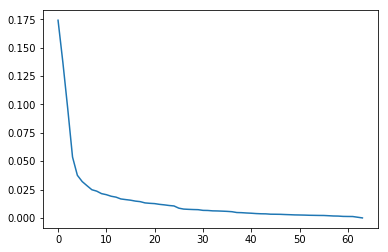

In [32]:
# Investigate the variance accounted for by each principal component.

print(pca.explained_variance_ratio_) 

plt.plot(pca.explained_variance_ratio_)

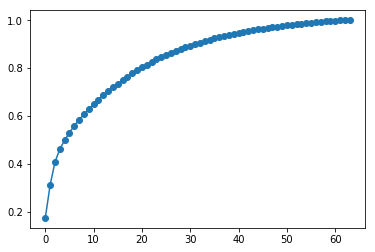

0.628878591585


In [33]:
# Show the cumulative variance accounted for versus number of PCA components retained
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
plt.show()

# Print how much variance covered by the first 10 components
print(np.cumsum(pca.explained_variance_ratio_)[9])

In [34]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=10)
X_pca = pd.DataFrame(pca.fit_transform(X_scaled))
X_pca.head()


,0,1,2,3,4,5,6,7,8,9
0,4.089724,-2.250581,-2.958354,-0.489322,2.460208,2.413340,1.016658,1.340902,-1.162177,-0.338371
1,-1.052953,0.044051,-3.096829,2.186817,0.942996,-0.182047,-0.856046,0.311385,-1.225640,0.007643
2,0.446222,0.201817,3.202872,0.455786,-1.551129,-2.898411,2.071929,1.061898,-0.727643,1.271768
3,-0.616516,-1.577358,-1.164391,-2.066565,3.198573,-0.740544,-0.434629,-2.431491,1.216732,-1.423352
4,0.578895,-3.149920,-3.645839,-0.431731,1.509442,-1.272438,-0.324812,-1.366676,2.405973,-0.636761


### Discussion 2.2: Perform Dimensionality Reduction

Our first chart above has an elbow around 10, which suggests there are diminishing returns (variance) captured beyond the first 10 principal components.

Our second chart looks at cumulative variance captured versus number of PCA components retained, again showing diminishing returns as the number of PCA components retained increases. We calculate that the first 10 PCA components capture 62.9% of the total variance.

Hence we elect to retain 10 principal components for the remainder of our analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [35]:
print(pca.components_.shape)

(10, 64)


In [36]:
print(list(subset1.columns))

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'YOUTH_DECADE', 'YOUTH_MOVEMENT', 'WEALTH', 'LIFE_STAGE']


In [37]:
evectors = pd.DataFrame(pca.components_, columns=X_scaled.columns)
evectors

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,YOUTH_DECADE,YOUTH_MOVEMENT,WEALTH,LIFE_STAGE
0,-0.147904,-0.003882,-0.222484,0.165815,-0.136351,0.087292,0.094741,0.144910,-0.115301,0.038564,-0.038518,0.052666,0.094596,0.131591,0.097790,-0.025192,-0.106024,-0.105163,0.092752,0.110212,-0.007376,0.013268,0.026914,0.134195,0.120266,-0.002060,0.018459,-0.077038,-0.005926,0.195056,0.023761,-0.069301,0.130111,0.030705,-0.156134,-0.034328,-0.060087,-0.218353,0.007874,0.131532,0.146316,-0.208101,-0.117022,0.181219,-0.154191,-0.110762,0.045746,-0.233061,-0.024035,0.072320,-0.078556,-0.215423,0.141629,0.213716,0.207551,0.035649,-0.162744,0.137236,0.184226,0.124980,0.126726,-0.115301,0.197156,-0.125978
1,0.245187,0.090215,0.040815,-0.217398,0.213828,-0.193506,-0.216888,0.130939,-0.030861,-0.048854,0.161125,-0.099298,-0.172196,-0.251535,-0.146232,-0.071703,0.169070,0.224264,-0.212143,-0.160649,0.122086,0.070563,0.115433,-0.225035,-0.218421,-0.002449,0.029858,-0.070339,0.006723,0.068501,0.119925,0.052494,0.073376,0.032877,-0.082884,-0.031162,-0.037311,-0.105502,-0.008139,0.062077,0.082804,-0.111169,-0.073053,0.110807,-0.091901,-0.052967,0.010722,-0.114833,-0.162885,0.031267,-0.045996,-0.116466,0.077960,0.117823,0.112917,0.014866,-0.092383,0.083184,0.110600,0.077828,-0.236760,-0.030861,0.092701,-0.017052
2,0.082355,-0.367636,0.156672,-0.101302,0.098250,-0.188288,-0.092781,-0.047400,0.050845,-0.010780,0.115999,0.263594,0.251417,0.076440,0.048777,0.348013,0.073306,-0.169770,0.231457,-0.219056,-0.268970,-0.312718,-0.337118,-0.076972,-0.086167,0.000489,0.020779,-0.005768,0.010445,-0.025998,0.094848,0.034891,0.026813,0.014525,-0.039303,-0.010531,-0.012423,-0.023550,-0.012045,0.007139,0.029294,-0.027819,-0.036919,0.049060,-0.044865,-0.031192,-0.016684,-0.030730,-0.055525,-0.005039,-0.021593,-0.046134,0.030338,0.045843,0.046399,0.006606,-0.037478,0.033023,0.048824,0.031364,-0.107610,0.050845,0.024854,-0.009348
3,-0.042250,0.042772,0.058342,-0.000426,-0.019924,-0.128416,0.088799,-0.101883,0.391591,0.003295,0.006182,-0.001436,-0.020616,-0.005395,0.024536,-0.014001,0.000147,-0.018800,-0.037118,0.055921,0.016681,0.116522,0.082512,0.019219,0.067383,0.001455,0.015888,0.095606,0.053042,-0.267418,-0.083168,0.006656,-0.020859,0.045640,-0.150079,-0.050273,0.105142,0.085449,-0.003399,-0.073930,-0.016932,0.041784,-0.240205,0.263700,-0.222989,-0.094948,-0.278399,0.050215,0.135611,-0.212005,0.039237,-0.054061,0.102512,0.099727,0.085553,0.129151,0.022816,0.050953,0.250295,0.093414,0.040816,0.391591,-0.130848,0.061287
4,-0.002109,-0.006252,-0.083669,0.000349,0.059336,-0.048758,0.043396,0.085698,-0.057438,-0.009534,0.030154,-0.004404,0.034220,0.006529,0.065836,-0.002743,0.014382,-0.022566,-0.014439,0.011180,0.023863,-0.009002,-0.030080,0.000238,0.028570,-0.003405,-0.006597,-0.136088,0.003966,0.058985,0.124608,-0.041797,0.026578,0.027966,-0.121574,-0.087319,0.205246,-0.093940,0.121197,0.074319,0.002937,-0.090380,0.039083,-0.040490,0.076368,-0.055667,-0.138592,-0.099174,-0.113577,-0.091275,0.517441,0.022998,0.105535,0.030231,-0.015684,0.495483,0.397827,-0.206727,-0.089168,-0.139474,-0.031969,-0.057438,0.007605,-0.026942
5,-0.005705,0.020200,-0.031604,0.001926,-0.026352,0.024536,-0.041298,0.052398,0.004980,-0.034073,-0.023025,0.015432,0.000543,-0.002028,0.007124,-0.007054,0.022872,

In [38]:
def show_comp_weights(component):
    print(evectors.iloc[component].sort_values(ascending=False))

In [39]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_comp_weights(0)

PLZ8_ANTG3               0.213716
PLZ8_ANTG4               0.207551
WEALTH                   0.197156
HH_EINKOMMEN_SCORE       0.195056
ORTSGR_KLS9              0.184226
EWDICHTE                 0.181219
FINANZ_SPARER            0.165815
KBA05_ANTG4              0.146316
FINANZ_HAUSBAUER         0.144910
PLZ8_ANTG2               0.141629
ARBEIT                   0.137236
SEMIO_PFLICHT            0.134195
SEMIO_REL                0.131591
KBA05_ANTG3              0.131532
ANZ_HAUSHALTE_AKTIV      0.130111
YOUTH_DECADE             0.126726
RELAT_AB                 0.124980
SEMIO_TRADV              0.120266
SEMIO_RAT                0.110212
SEMIO_MAT                0.097790
FINANZ_UNAUFFAELLIGER    0.094741
SEMIO_FAM                0.094596
SEMIO_KULT               0.092752
FINANZ_ANLEGER           0.087292
REGIOTYP                 0.072320
SEMIO_SOZ                0.052666
KKK                      0.045746
HEALTH_TYP               0.038564
PLZ8_HHZ                 0.035649
ANZ_HH_TITEL  

In [40]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_comp_weights(1)

ALTERSKATEGORIE_GROB     0.245187
SEMIO_ERL                0.224264
FINANZ_VORSORGER         0.213828
SEMIO_LUST               0.169070
RETOURTYP_BK_S           0.161125
FINANZ_HAUSBAUER         0.130939
SEMIO_KRIT               0.122086
W_KEIT_KIND_HH           0.119925
PLZ8_ANTG3               0.117823
SEMIO_KAEM               0.115433
PLZ8_ANTG4               0.112917
EWDICHTE                 0.110807
ORTSGR_KLS9              0.110600
WEALTH                   0.092701
ANREDE_KZ                0.090215
ARBEIT                   0.083184
KBA05_ANTG4              0.082804
PLZ8_ANTG2               0.077960
RELAT_AB                 0.077828
ANZ_HAUSHALTE_AKTIV      0.073376
SEMIO_DOM                0.070563
HH_EINKOMMEN_SCORE       0.068501
KBA05_ANTG3              0.062077
WOHNDAUER_2008           0.052494
FINANZ_MINIMALIST        0.040815
ANZ_HH_TITEL             0.032877
REGIOTYP                 0.031267
VERS_TYP                 0.029858
PLZ8_HHZ                 0.014866
KKK           

In [41]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_comp_weights(2)

SEMIO_VERT               0.348013
SEMIO_SOZ                0.263594
SEMIO_FAM                0.251417
SEMIO_KULT               0.231457
FINANZ_MINIMALIST        0.156672
RETOURTYP_BK_S           0.115999
FINANZ_VORSORGER         0.098250
W_KEIT_KIND_HH           0.094848
ALTERSKATEGORIE_GROB     0.082355
SEMIO_REL                0.076440
SEMIO_LUST               0.073306
GREEN_AVANTGARDE         0.050845
YOUTH_MOVEMENT           0.050845
EWDICHTE                 0.049060
ORTSGR_KLS9              0.048824
SEMIO_MAT                0.048777
PLZ8_ANTG4               0.046399
PLZ8_ANTG3               0.045843
WOHNDAUER_2008           0.034891
ARBEIT                   0.033023
RELAT_AB                 0.031364
PLZ8_ANTG2               0.030338
KBA05_ANTG4              0.029294
ANZ_HAUSHALTE_AKTIV      0.026813
WEALTH                   0.024854
VERS_TYP                 0.020779
ANZ_HH_TITEL             0.014525
ANZ_TITEL                0.010445
KBA05_ANTG3              0.007139
PLZ8_HHZ      

### Discussion 2.3: Interpret Principal Components

Above, we have a grid listing our 10 principal components and their composition across our remaining 69 features.

A positive weight value in this grid signifies that the principal component is correlated positively (will move in the same direction) with a change in the corresponding underlying feature.

A negative weight value signifies that the principal component is correlated negatively (will move in the opposite direction) with a change in the corresponding underlying feature.

#### Principal Component 1
* Strong positive weights in PLZ8_ANTG3/PLZ8_ANTG4 (family houses) and WEALTH
* Strong negative weights in FINANZ_MINIMALIST (low financial interest) and MOBI_REGIO (movement patterns)
* This PCA feature is about how well off people are (high wealth and number of family homes), couples with high level of financial interest and low mobility (stable location).

#### Principal Component 2
* Strong positive weights in ALTERSKATEGORIE_GROB (estimated age) and SEMIO_ERL (low affinity event oriented). 
* Strong negative weights in YOUTH_DECADE (lower decade means older) and SEMIO_REL (low affinity religious).
* This PCA feature is about how old people are, coupled with high interest in religion and low interest in events.

#### Principal Component 3
* Strong positive weights in SEMIO_VERT (low dreamful affinity), SEMIO_SOZ (low socially minded), SEMIO_FAM (low family affinity) and SEMIO_KULT (low cultural interest).
* Strong negative weights in SEMIO_KRIT (low critical-minded), SEMIO_DOM (low dominant minded), SEMIO_KAEM (low combative attitude) and ANREDE_KZ (female)
* Those high on this PCA feature are critical-minded, dominant minded, combative, likely male with low interest in dreamfulness, socially minded, families and culture.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [42]:
scores = []
centers = []
count = X_pca.shape[0]

# Over a number of different cluster counts...
for k in range(2, 20, 2):

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(X_pca)

    # compute the average within-cluster distances
    # Kmeans score is SSE - need to divide by count to get average distance
    centers.append(k)
    scores.append(abs(kmeans.score(X_pca)) / count)



[31.949128360519413, 24.846384762766462, 21.405545060955088, 18.896262311931952, 17.507337216408626, 16.542138643166496, 15.858139179069894, 15.234260210328646, 14.675516563202775]


Text(0.5,1,'Mean Distance vs. K')

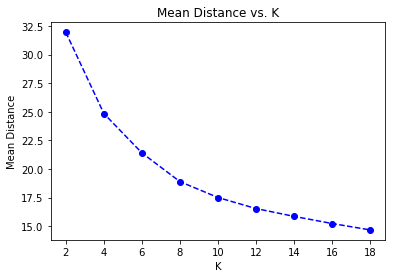

In [43]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

print(scores)
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Mean Distance')
plt.title('Mean Distance vs. K')

In [44]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=10)
labels_genpop = pd.Series(kmeans.fit_predict(X_pca))

### Discussion 3.1: Apply Clustering to General Population


As the chart above illustrates, the mean error distance decreases as the number of cluster increases, although the incremental gain continues to decrease. However, a larger number of clusters takes longer to compute and is less likely to produce meaningful collections for business inference purposes. We seek to find a balance between these factors by selecting 10 as our number of clusters for further analysis.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [45]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';', na_values=['X', 'XX'])

customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1.0,1A,13.0,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5.0,5D,34.0,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4.0,4C,24.0,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7.0,7B,41.0,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [46]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

X_cust = clean_data(customers)

In [47]:
X_cust.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,YOUTH_DECADE,YOUTH_MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,1,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,50,1,1.0,3.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,0.0,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,1,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,50,1,3.0,4.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,5.0,4.0,5.0,4.0,6.0,5.0,6.0,4.0,5.0,5.0,3.0,5.0,2.0,5.0,4.0,0.0,2.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,1,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,1.0,70,0,4.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,3.0,6.0,4.0,4.0,1.0,7.0,6.0,4.0,6.0,2.0,5.0,5.0,3.0,3.0,4.0,0.0,2.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1992.0,1,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,5.0,5.0,3.0,7.0,5.0,50,1,3.0,4.0
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,5.0,4.0,2.0,5.0,1.0,6.0,5.0,3.0,4.0,3.0,3.0,1.0,2.0,2.0,4.0,0.0,1.0,2.0,0.0,2.0,6.0,9.0,1.0,0.0,4.0,1992.0,1,4.0,1.0,0.0,0.0,4.0,6.0,2.0,5.0,4.0,2.0,4.0,4.0,3.0,1300.0,3.0,2.0,1.0,0.0,5.0,5.0,2.0,3.0,2.0,50,1,2.0,3.0


In [48]:
X_cust.dropna(axis=0, inplace=True)
X_cust_scaled = pd.DataFrame(scaler.transform(X_cust), columns=X_cust.columns)
X_cust_pca = pd.DataFrame(pca.transform(X_cust_scaled))
labels_cust = pd.Series(kmeans.predict(X_cust_pca))


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

   cust_freq_pct  genpop_freq_pct
0       1.314390         9.522297
1      11.004557        13.070052
2      13.013325         8.019756
3       0.905373        10.054540
4       0.972822         8.995188
5      16.946119        10.808859
6       7.844833        10.391184
7      37.062338         8.315322
8       9.253478        13.163118
9       1.682765         7.659685


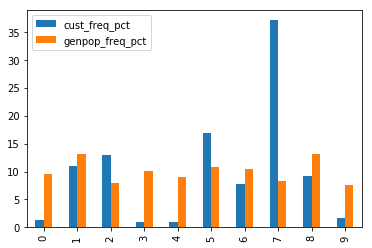

In [49]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
labels_cust_df = pd.DataFrame(100 * labels_cust.value_counts(normalize=True), columns=['cust_freq_pct']).sort_index()
labels_genpop_df = pd.DataFrame(100 * labels_genpop.value_counts(normalize=True), columns=['genpop_freq_pct']).sort_index()

labels_df = labels_cust_df.join(labels_genpop_df, how="inner")
print(labels_df)

labels_df.plot(kind="bar")

In [53]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 7 is over-represented in customers versus general population.

# Reverse transform to map back to original feature space
cc_over_pca = kmeans.cluster_centers_[7]
cc_over_scaled = pd.Series(pca.inverse_transform(cc_over_pca), index=subset1.columns)
cc_over = pd.Series(scaler.inverse_transform(cc_over_scaled), index=subset1.columns)
cc_over

ALTERSKATEGORIE_GROB        3.316846
ANREDE_KZ                   1.066115
FINANZ_MINIMALIST           4.807930
FINANZ_SPARER               1.542449
FINANZ_VORSORGER            4.271526
FINANZ_ANLEGER              1.328662
FINANZ_UNAUFFAELLIGER       2.099588
FINANZ_HAUSBAUER            2.025922
GREEN_AVANTGARDE            0.824495
HEALTH_TYP                  2.010792
RETOURTYP_BK_S              3.989094
SEMIO_SOZ                   5.322583
SEMIO_FAM                   4.831031
SEMIO_REL                   3.718318
SEMIO_MAT                   3.840795
SEMIO_VERT                  6.226545
SEMIO_LUST                  5.380846
SEMIO_ERL                   4.131900
SEMIO_KULT                  4.849130
SEMIO_RAT                   2.669666
SEMIO_KRIT                  3.202946
SEMIO_DOM                   3.338991
SEMIO_KAEM                  2.627687
SEMIO_PFLICHT               3.189865
SEMIO_TRADV                 3.123057
SOHO_KZ                     0.009589
VERS_TYP                    1.472364
A

In [54]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 3 is under-represented in customers versus general population.

# Reverse transform to map back to original feature space
cc_under_pca = kmeans.cluster_centers_[3]
cc_under_scaled = pd.Series(pca.inverse_transform(cc_under_pca), index=subset1.columns)
cc_under = pd.Series(scaler.inverse_transform(cc_under_scaled), index=subset1.columns)
cc_under


ALTERSKATEGORIE_GROB        1.591503
ANREDE_KZ                   2.018886
FINANZ_MINIMALIST           1.092503
FINANZ_SPARER               4.341458
FINANZ_VORSORGER            2.042700
FINANZ_ANLEGER              4.170190
FINANZ_UNAUFFAELLIGER       3.723474
FINANZ_HAUSBAUER            4.158597
GREEN_AVANTGARDE            0.034482
HEALTH_TYP                  2.170842
RETOURTYP_BK_S              2.575162
SEMIO_SOZ                   3.348317
SEMIO_FAM                   3.877719
SEMIO_REL                   5.248433
SEMIO_MAT                   5.165221
SEMIO_VERT                  2.262747
SEMIO_LUST                  2.636997
SEMIO_ERL                   4.161090
SEMIO_KULT                  4.162861
SEMIO_RAT                   6.324617
SEMIO_KRIT                  5.539484
SEMIO_DOM                   6.277313
SEMIO_KAEM                  6.254149
SEMIO_PFLICHT               6.297169
SEMIO_TRADV                 5.836269
SOHO_KZ                     0.007505
VERS_TYP                    1.382381
A

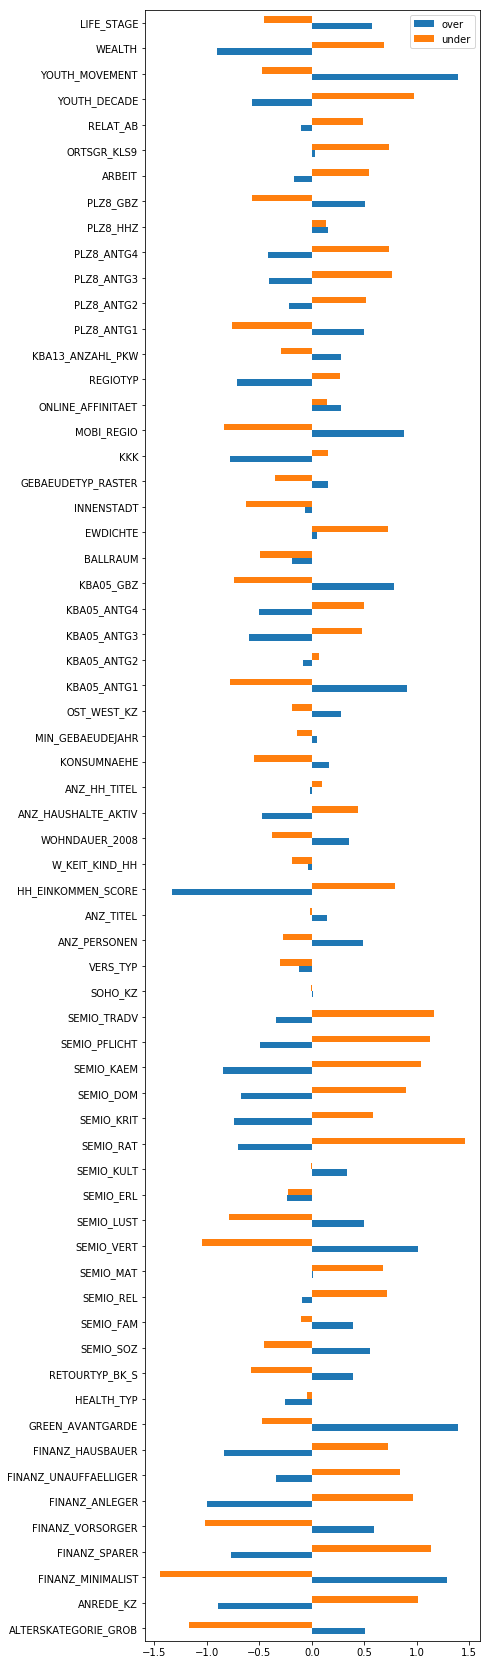

In [55]:
# Identify which features over- and under-represented differ most on
cc_over_scaled_df = pd.DataFrame(cc_over_scaled, columns=["over"])
cc_under_scaled_df = pd.DataFrame(cc_under_scaled, columns=["under"])
cc_scaled_df = cc_over_scaled_df.join(cc_under_scaled_df, how="inner")
cc_scaled_df.plot(kind="barh", figsize = (6, 30))

### Discussion 3.3: Compare Customer Data to Demographics Data


We have charted the distribution of both our customers and the general population across our 10 clusters.

We have picked out two clusters for further analysis - the one where our customers are most over-represented versus the general population and the one where we are most under-represented.

We have mapped the centers of these two clusters back to the scaled versions of our original source features and plotted the values for each feature. We can now look at which features have the greatest difference between the under- and over-represented clusters.

Here are some sample observations:
* Youth decade is much higher for our under-represented cluster. i.e. our customers are older than the general population.
* Life stage is later for our over-represented cluster. This aligns with the previous point on youth decade.
* Youth movement is dominated by Avantgarde in our over-represented cluster but more mainstream in our under-represented cluster.
* Most of the SEMIO (personality typology) features are pointing in opposite directions, suggesting that our customers are not a representative sample of the general population in terms of behaviour and attitudes.
* ANREDE_KZ (gender) is significantly different, suggesting we are over-represented in Males and under-represented in Females.
* Lots more per-feature analysis can be conducted here.

This suggests our company's customer base is under-represented in younger and female customers. We should target these customer segements through our marketing efforts.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.